In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers

from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('data/winemag-data_first150k.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [6]:
# 保留"country"和"price"属性非空的数据，去掉第一列"Unnamed"
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0],axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137230 entries, 0 to 150929
Data columns (total 10 columns):
country        137230 non-null object
description    137230 non-null object
designation    94919 non-null object
points         137230 non-null int64
price          137230 non-null float64
province       137230 non-null object
region_1       114393 non-null object
region_2       60704 non-null object
variety        137230 non-null object
winery         137230 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 11.5+ MB


In [9]:
len(data['variety'].unique())

619

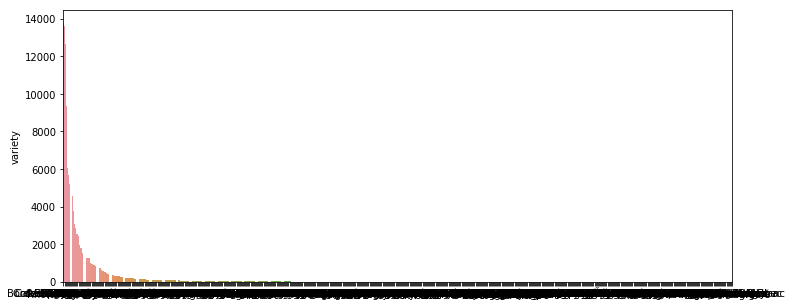

In [35]:
import seaborn 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
seaborn.barplot(x=data.variety.value_counts().index, y=data.variety.value_counts())
plt.show()

In [44]:
# 去掉出现次数少于500的"variety"数据

variety_threshold = 500
value_counts = data['variety'].value_counts()
to_move = value_counts[value_counts <= variety_threshold].index
data.replace(to_move, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

In [45]:
len(data)

119559

In [47]:
# 将数据分为训练集和测试集

train_size = int(len(data)*0.8)
print("Train size: %d" % train_size)
print("Test size: %d" % (len(data)-train_size))

Train size: 95647
Test size: 23912


In [48]:
# 训练集

description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

labels_train = data['price'][:train_size]

In [49]:
# 测试集

description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

labels_test = data['price'][train_size:]

### 特征一: description 

To create a wide representation of our text descriptions we’ll use a bag of words model.

In [52]:
# 创建分词器 Tokenizer 对象

vocab_size = 12000      # 需要保留的最大词数，基于词频
tokenize = Tokenizer(num_words=vocab_size, char_level=False)
tokenize.fit_on_texts(description_train)      # 拟合训练预料，生成新的Tokenizer

In [54]:
#  将文本转换为矩阵表示，形如(len(texts), nb_words)的numpy array
#  convert each description to a bag of words vector

description_bow_train = tokenize.texts_to_matrix(description_train)
description_bow_test = tokenize.texts_to_matrix(description_test)

In [55]:
description_bow_train.shape

(95647, 12000)

In [56]:
description_bow_train[0,:]

array([0., 1., 1., ..., 0., 0., 0.])

### 特征二：variety

We’ll use a Keras utility to convert each of these varieties to integer representation, and then we’ll create 40-element wide one-hot vectors for each input to indicate the variety.

In [58]:
# Label标准化，将标签分配一个0—n_classes-1之间连续的编码 

encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

In [61]:
variety_train

array([ 5, 31, 20, ...,  5, 39,  9])

In [63]:
variety_train.shape

(95647,)

In [64]:
num_classes

40

In [65]:
# 类别标签转换为onehot编码

variety_train = to_categorical(variety_train, num_classes)
variety_test = to_categorical(variety_test, num_classes)

In [66]:
variety_train.shape

(95647, 40)

In [67]:
variety_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

### Building the wide model with the Keras functional API

 Wide models are models with sparse feature vectors, or vectors with mostly zero values.

In [69]:
bow_inputs = layers.Input(shape=(vocab_size,))
variety_inputs = layers.Input(shape=(num_classes,))

merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)

wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [70]:
# 优化学习过程

wide_model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

print(wide_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12040)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          3082496     concatenate_1[0][0]              
__________

### "description"词嵌入

In [71]:
# 将文本向量化

train_embed = tokenize.texts_to_sequences(description_train)
test_embed = tokenize.texts_to_sequences(description_test)

In [73]:
# 短于maxlen长度的序列在后部填充0以达到该长度

max_seq_length = 170

train_embed = pad_sequences(train_embed, maxlen=max_seq_length, padding="post")    
test_embed = pad_sequences(test_embed, maxlen=max_seq_length, padding="post")


In [74]:
train_embed

array([[   6, 1585,  378, ...,    0,    0,    0],
       [6895,    2, 3626, ...,    0,    0,    0],
       [   6, 1552,  586, ...,    0,    0,    0],
       ...,
       [4123,  127,   13, ...,    0,    0,    0],
       [ 138,  847,   33, ...,    0,    0,    0],
       [  40, 3580,    5, ...,    0,    0,    0]])

In [84]:
train_embed.shape

(95647, 170)

### Building the deep model with the Keras functional API

In [75]:
deep_inputs = layers.Input(shape=(max_seq_length,))

embedding = layers.Embedding(vocab_size, 8, input_length=max_seq_length)(deep_inputs)  # 将正整数（索引值）转换为固定尺寸的稠密向量。 例如： [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
embedding = layers.Flatten()(embedding)   # 多维的输入一维化
embed_out = layers.Dense(1)(embedding)

deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 8)            96000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1361      
Total params: 97,361
Trainable params: 97,361
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
# 优化学习过程

deep_model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])                      

### Combine wide and deep into one model

We simply need to create a layer that concatenates the outputs from each model, then merge them into a fully connected Dense layer, and finally define a combined model that combines the input and output from each one.

In [77]:
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)

combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 170)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12040)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________

In [78]:
# 优化学习过程

combined_model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])                       

In [79]:
# 训练 epochs: 训练模型迭代轮次   batch_size：每次提度更新的样本数

combined_model.fit([description_bow_train, variety_train] + [train_embed], labels_train, epochs=10, batch_size=128)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
95647/95647 [==============================] - 168s 2ms/step - loss: 1275.9481 - acc: 0.0270
Epoch 2/10
95647/95647 [==============================] - 162s 2ms/step - loss: 994.4362 - acc: 0.0360
Epoch 3/10
95647/95647 [==============================] - 132s 1ms/step - loss: 855.0108 - acc: 0.0389 5
Epoch 4/10
95647/95647 [==============================] - 134s 1ms/step - loss: 723.9951 - acc: 0.0423
Epoch 5/10
95647/95647 [==============================] - 133s 1ms/step - loss: 601.9883 - acc: 0.0453
Epoch 6/10
95647/95647 [==============================] - 132s 1ms/step - loss: 490.8102 - acc: 0.0512
Epoch 7/10
95647/95647 [==============================] - 129s 1ms/step - loss: 389.3276 - acc: 0.0582
Epoch 8/10
95647/95647 [==============================] - 119s 1ms/step - loss: 305.5666 - acc: 0.0655
Epoch 9/10
95647/95647 [==============================] - 127s 1ms/step - loss: 235.7893 - acc: 0.0729
Epoch 10/10
95647/9564

In [80]:
# 在测试模式下返回模型的误差值和评估标准值

combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=128)


23912/23912 [==============================] - 20s 848us/step


[365.03259323671455, 0.0792489126897967]

In [81]:
# 预测

predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])


In [82]:
# 取测试集中的前15个，对比预测价格和真实价格

num_predictions = 15
diff = 0

for i in range(num_predictions):
    val = predictions[i]
    print(description_test.iloc[i])
    print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
    diff += abs(val[0] - labels_test.iloc[i])

H3 is Columbia Crest's line of wines from the Horse Heaven Hills AVA—the winery's home turf—and the wines seem to have a bit more cut and flair than the slightly less expensive Columbia Valley bottlings. Here you will find a more complex blend of fruits—starfruit, apple, melon and a hint of banana—and less focus on butter and toast. In other words, more of a food and sipping wine.
Predicted:  17.511314 Actual:  15.0 

Very ripe and fruity in the modern style, almost too strong in blackberry jam, black currant and oak flavors that are not particularly subtle or delicate, although the wine is thoroughly dry. The tannins are significant, but negotiable. The suggestion is ageability. Give it 2–4 years and try again.
Predicted:  43.4903 Actual:  45.0 

Notes of olive and bay leaves add some interesting complexity to the nose of this blend, otherwise dominated by typical red berry flavors. Ripe and rich on the palate with medium acidity and lighter tannins. The finish, dominated by beautiful

In [83]:
# 平均偏差

print('Average prediction difference: ', diff / num_predictions)

Average prediction difference:  4.9942466735839846
